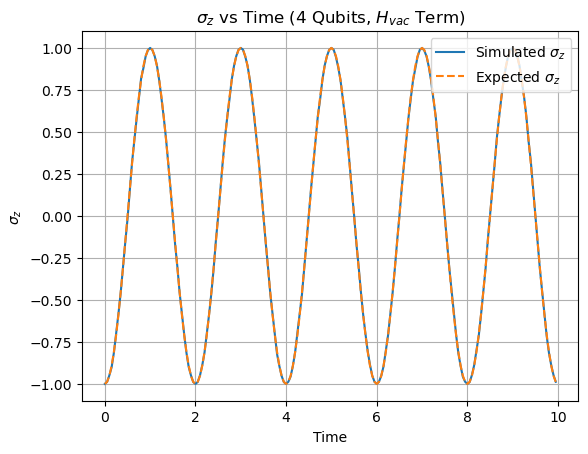

In [2]:
# main_vac_osc script 

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector, Operator
import sys
import os

# Determine the correct path for the 'src' directory
if '__file__' in globals():
    # Running as a script
    src_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'src'))
else:
    # Running in an interactive environment like Jupyter Notebook
    src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

sys.path.append(src_dir)

from hamiltonian import construct_hamiltonian
from evolve import evolve_and_measure_circuit

def initialize_parameters():
    N_sites = 4  # Number of qubits
    delta_m_squared = np.pi
    omega_a = np.full(N_sites // 2, delta_m_squared)
    omega_b = np.full(N_sites // 2, delta_m_squared)
    omega = np.concatenate((omega_a, omega_b))
    B = [1, 0, 0]
    shots = 10246
    backend = AerSimulator(method='automatic')
    tolerance = 5e-1
    τ = 0.05  # Time step
    ttotal = 10  # Total time
    times = np.arange(0, ttotal, τ)  # Define time steps
    mu = 0 
    interaction_strength = mu / (2 * N_sites)

    return N_sites, mu, omega, B, interaction_strength, shots, backend, tolerance, τ, times

def simulate(times, omega, N_sites, H, backend, shots, τ, tolerance):
    sigma_z_values = []
    expected_sz_array = []

    for t in times:
        expected_sz = [-1 * np.cos(omega_i * t) for omega_i in omega]
        expected_sz_array.append(np.mean(expected_sz) if expected_sz else None)
        
        qc = evolve_and_measure_circuit(t, H, N_sites)
        result = backend.run(qc, shots=shots).result()    
        counts = result.get_counts(qc)
        
        sigma_z = sum((count / shots if outcome[0] == '0' else -count / shots) for outcome, count in counts.items())
        sigma_z_values.append(sigma_z)
    
    assert all(abs(np.array(sigma_z_values) - np.array(expected_sz_array)) < tolerance), "Assertion failed: values differ more than tolerance"

    return sigma_z_values, expected_sz_array

def plot_results(times, sigma_z_values, expected_sz_array, N_sites):
    plt.plot(times, sigma_z_values, label='Simulated $\sigma_z$')
    plt.plot(times, expected_sz_array, label='Expected $\sigma_z$', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('$\sigma_z$')
    plt.title(f'$\sigma_z$ vs Time ({N_sites} Qubits, $H_{{vac}}$ Term)')
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

def main():
    N_sites, mu, omega, B, interaction_strength, shots, backend, tolerance, τ, times = initialize_parameters()
    H = construct_hamiltonian(N_sites, interaction_strength, omega, B)
    sigma_z_values, expected_sz_array = simulate(times, omega, N_sites, H, backend, shots, τ, tolerance)
    plot_results(times, sigma_z_values, expected_sz_array, N_sites)

if __name__ == "__main__":
    main()

